## Exercise Sheet 7: Variational Autoencoders

In [10]:
import os
import random
import time
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

# Import Pytorch, Sklearn
from sklearn.manifold import TSNE
import torch 
import torch.nn as nn
from torch.nn import functional as F

# Load FashionMNIST dataset
from torchvision import datasets, transforms

# set figure size
plt.figure(figsize=(10, 5))

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlesize'] = 8
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

<Figure size 1000x500 with 0 Axes>

In [22]:
# set random seed
random.seed(42)
torch.manual_seed(42)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

########################
##### HOUSEKEEPING #####

# set hyperparameters
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5

# set directories
RESULTS_DIR = 'results/'
DATA_DIR = 'data/'
MODEL_DIR = 'models/'

########################
########################

# if don't exist, create directories
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

Using device: cpu


In [23]:
import torch 
import torch.nn as nn

class VAE(nn.Module):

    def __init__(self, num_channels=1, num_classes=10, latent_dim=2, embed_dim=16):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        self.embedding = nn.Embedding(num_embeddings=num_classes, embedding_dim=embed_dim)

        # Encoder
        self.encoder = nn.ModuleList([
            nn.Conv2d(in_channels=num_channels, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        ])

        # Decoder
        self.decoder = nn.ModuleList([
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3),
            nn.Conv2d(in_channels=8, out_channels=num_channels, kernel_size=3, padding=1),
        ])

        # Fully connected layers for learning representations
        self.fc_latent = nn.Linear(in_features=latent_dim + embed_dim, out_features=512)

        self.fc_mean = nn.Linear(in_features=512 + embed_dim, out_features=latent_dim)
        self.fc_var = nn.Linear(in_features=512 + embed_dim, out_features=latent_dim)
        self.leaky_relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        x_recon = self.decode(z, y)
        return x_recon, mean, log_var

    def encode(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            mean (tensor): Mean of shape [B, latent_dim]. 
            log_var (tensor): Log variance of shape [B, latent_dim].
        """
        for layer in self.encoder:
            x = layer(x)
            x = self.leaky_relu(x)
        x = torch.reshape(x, (x.shape[0], -1))
        class_embed = self.embedding(y)
        # Concat class information
        mean = self.fc_mean(torch.cat((x, class_embed), dim=1))
        log_var = self.fc_var(torch.cat((x, class_embed), dim=1))
        return mean, log_var

    def decode(self, z, y):
        """
        Args:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            x (tensor): Reconstructed image(s) of shape [B, C, H, W].
        """
        class_embed = self.embedding(y)
        # Concat class information
        x = self.fc_latent(torch.cat((z, class_embed), dim=1))
        x = torch.reshape(x, (-1, 32, 4, 4))
        for layer in self.decoder:
            x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
            x = self.leaky_relu(x)
            x = layer(x)
        x = self.sigmoid(x)
        return x

    def sample(self, y, device):
        """
        Args:
            y (int): Class label.
            device (torch.device): Which device to use (cuda or cpu).

        Returns:
            (tensor): Image of shape [1, C, H, W].
        """
        z = torch.randn((1, self.latent_dim), device=device)
        return self.decode(z, torch.tensor([y], device=device))

    def sample_latent(self, x, y):
        """
        Args:
            x (tensor): Image(s) of shape [B, C, H, W].
            y (tensor): Class label(s) of shape [B,].

        Returns:
            z (tensor): Latent variable(s) of shape [B, latent_dim].
        """
        mean, log_var = self.encode(x, y)
        # Reparameterization Trick
        eps = torch.randn(log_var.shape, device=log_var.device)
        z = mean + torch.exp(log_var * 0.5) * eps
        return z

### Task 1: Training a Variational Autoencoder on MNIST

In [24]:
# Task 1.1 Download the MNIST dataset

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the training dataset
trainset = datasets.MNIST(DATA_DIR, download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

# Download and load the test dataset
testset = datasets.MNIST(DATA_DIR, download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

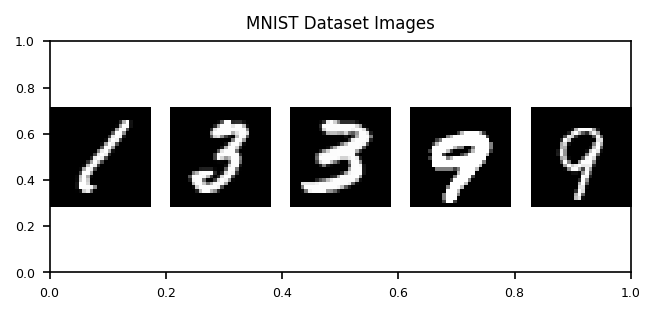

<Figure size 960x720 with 0 Axes>

In [25]:
num_images = 5

# Plot the images from trainloader
plt.figure(figsize=(num_images, 2))
plt.title('MNIST Dataset Images')
# place it on GPU if available
dataiter = iter(trainloader) 
for i in range(num_images):
    # Get the next batch of images
    images, _ = next(dataiter)

    # Plot the first image in the batch
    plt.subplot(1, num_images, i + 1)
    plt.imshow(images[0].numpy().squeeze(), cmap='gray')
    plt.axis('off')

plt.show()
plt.savefig(RESULTS_DIR + 'mnist_dataset_images.png')

In [26]:
# Task 1.1 Write pytorch code for loss function (BCE + KL Divergence)
#          L(x(i),θ,φ) = −Ez ∼qφ(z|x(i))[log pθ(x(i)|z)] + DKL(qφ(z|x(i)) ∥pθ(z))

def loss_function(x, x_recon, mean, log_var, KL_weight=1e-3):
    """
    Args:
        x (tensor): Image(s) of shape [B, C, H, W].
        x_recon (tensor): Reconstructed image(s) of shape [B, C, H, W].
        mean (tensor): Mean of shape [B, latent_dim]. 
        log_var (tensor): Log variance of shape [B, latent_dim].

    Returns:
        loss (tensor): Loss value.
    """
    # Ensure the input and output are of the same shape
    assert x.shape == x_recon.shape, "x and x_recon must have the same shape"
    
    # BCE Loss -- reconstruction loss
    BCE_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    # KL Divergence -- regularization loss
    KL_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    # Total loss -- balance between the two
    return BCE_loss + (KL_weight * KL_loss)

In [27]:
# Task 1.2 Implement the VAE model
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [28]:
def train(model, optimizer, epochs, trainloader, device):
    """
    Train VAE model and plot sample image per class after each epoch.

    Args:
        model (nn.Module): VAE model.
        optimizer (torch.optim): Optimizer.
        epochs (int): Number of epochs.
        trainloader (DataLoader): Training data loader.
        device (torch.device): Which device to use (cuda or cpu).
    
    Returns:
        None
    """

    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for i, (images, labels) in enumerate(trainloader):
            x = images.to(device)
            y = labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            x_recon, mean, log_var = model(x, y)
            loss = loss_function(images, x_recon, mean, log_var)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print(f'Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(trainloader.dataset):.6f}')

        # Plot sample image per class
        sample_images = []
        for i in range(10):
            sample_images.append(model.sample(i, device).cpu().detach().numpy())

        plt.figure(figsize=(10, 1))
        plt.suptitle(f'Epoch {epoch + 1}/{epochs} - Sample Images')
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            plt.imshow(sample_images[i].squeeze(), cmap='gray')
            plt.axis('off')
        plt.show()
        plt.savefig(RESULTS_DIR + f'sample_images_epoch_{epoch + 1}.png')

In [29]:
# train the VAE model
train(vae, optimizer, EPOCHS, trainloader, device)

### Task 2: Vsiaulize the latent space

In [ ]:
def plot_latent_space(vae, dataloader, n=1000, figsize=5, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """ Posterior sampling based on a given image. Extract the latent space and plot it using t-SNE.

    Args:
        vae (nn.Module): VAE model.
        dataloader (DataLoader): Dataloader to use for sampling from the true data distribution.
        n (int): Number of samples to plot.
        figsize (int): Size of the figure.
        method (str): Method to use for projecting the latent space to 2D. Should be 'TSNE'.
        device (torch.device): Device to use for tensor operations.

    Returns:
        None
    """
    vae.eval()

    # Sample a large number of points from the true data distribution and encode to obtain latent space samples
    latents = []
    labels = []
    with torch.no_grad():
        for i, (data, label) in enumerate(dataloader):
            if len(latents) >= n:
                break
            data = data.to(device)
            label = label.to(device)
            latent = vae.sample_latent(data, label)
            latents.append(latent)
            labels.append(label)
        latents = torch.cat(latents, dim=0)
        labels = torch.cat(labels, dim=0)

    # Project the latent space to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    latents_2d = tsne.fit_transform(latents.cpu().numpy())

    # Plot the latent space
    plt.figure(figsize=(figsize, figsize))
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space')
    for i in range(10):
        plt.scatter(latents_2d[labels == i, 0], latents_2d[labels == i, 1], label=str(i), s=1)
    plt.legend()
    plt.grid()
    plt.savefig(RESULTS_DIR + 'vae_latent_space.png')
    plt.show()


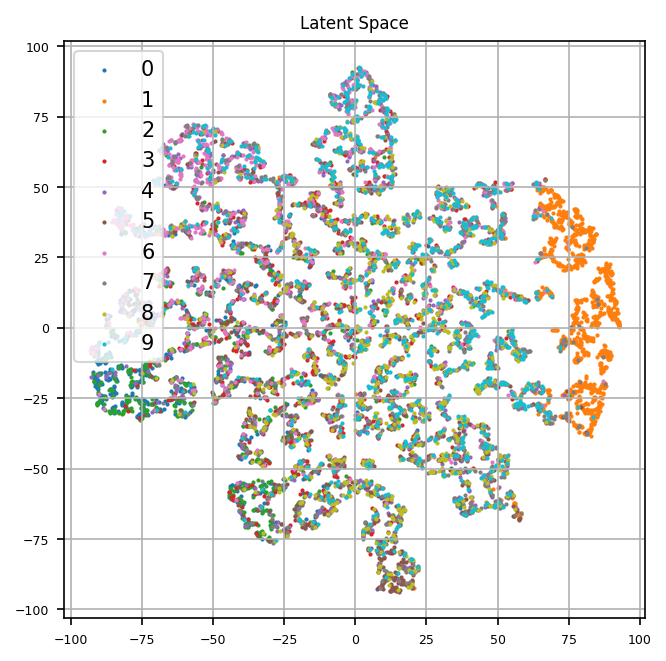

In [ ]:
# Visualize the latent space
plot_latent_space(vae, testloader, n=1000, figsize=5, device=device)

### Task 3: Anomaly Detection using a Variational Autoencder

In [ ]:
# Download the Fashion MINST dataset

